# About this notebook
- PyTorch tf_efficientnet_b7_ns starter code
- StratifiedKFold 5 folds
- Training notebook is [here](https://www.kaggle.com/yasufuminakama/g2net-efficientnet-b7-baseline-training)
- Spectrogram generation code
    - https://www.kaggle.com/yasufuminakama/g2net-n-mels-128-train-images is generated by https://www.kaggle.com/yasufuminakama/g2net-spectrogram-generation-train
    - https://www.kaggle.com/yasufuminakama/g2net-n-mels-128-test-images is generated by https://www.kaggle.com/yasufuminakama/g2net-spectrogram-generation-test
- version 3: melspectrogram approach using above dataset
- version 4: nnAudio Q-transform approach
    - Here is nnAudio Constant Q-transform Demonstration
        - https://www.kaggle.com/atamazian/nnaudio-constant-q-transform-demonstration
        - https://www.kaggle.com/c/g2net-gravitational-wave-detection/discussion/250621
    - Thanks for sharing @atamazian
- version 6: tf_efficientnet_b0_ns -> tf_efficientnet_b7_ns
- version 7: update model

If this notebook is helpful, feel free to upvote :)

In [ ]:
import IPython.display
IPython.display.YouTubeVideo('hhbMpe17fzA', width=800, height=500)

In [2]:
# CFG

In [24]:
# ====================================================
# CFG
# ====================================================
class CFG:
    debug=False
    num_workers=4
    model_name='tf_efficientnetv2_l_in21k'
    model_dir='eff_v2_21k/'
    batch_size=512
    qtransform_params={"sr": 2048, "fmin": 20, "fmax": 1024, "hop_length": 32, "bins_per_octave": 8}
    seed=42
    target_size=1
    target_col='target'
    n_fold=5
    trn_fold=[0, 1, 2, 3, 4]

# Library

# Utils

In [25]:
# ====================================================
# Library
# ====================================================
import sys
sys.path.append('../input/pytorch-image-models/pytorch-image-models-master')

import os
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter

import scipy as sp
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

from tqdm.auto import tqdm
from functools import partial

import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

import timm

from torch.cuda.amp import autocast, GradScaler

from nnAudio.Spectrogram import CQT1992v2

import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [26]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    score = roc_auc_score(y_true, y_pred)
    return score


def get_result(result_df):
    preds = result_df['preds'].values
    labels = result_df['target'].values
    score = get_score(labels, preds)
    return score
    

def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed=CFG.seed)

# Data Loading

In [27]:
test = pd.read_csv('input/sample_submission.csv')

if CFG.debug:
    test = test.sample(n=1000, random_state=CFG.seed).reset_index(drop=True)

def get_test_file_path(image_id):
    return "input/test/{}/{}/{}/{}.npy".format(
        image_id[0], image_id[1], image_id[2], image_id)

test['file_path'] = test['id'].apply(get_test_file_path)

display(test.head())

,id,target,file_path
0,00005bced6,0.5,input/test/0/0/0/00005bced6.npy
1,0000806717,0.5,input/test/0/0/0/0000806717.npy
2,0000ef4fe1,0.5,input/test/0/0/0/0000ef4fe1.npy
3,00020de251,0.5,input/test/0/0/0/00020de251.npy
4,00024887b5,0.5,input/test/0/0/0/00024887b5.npy


# Dataset

In [28]:
# ====================================================
# Dataset
# ====================================================
class TestDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['file_path'].values
        self.wave_transform = CQT1992v2(**CFG.qtransform_params)
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def apply_qtransform(self, waves, transform):
        waves = np.hstack(waves)
        waves = waves / np.max(waves)
        waves = torch.from_numpy(waves).float()
        image = transform(waves)
        return image
    
    def __getitem__(self, idx):
        file_path = self.file_names[idx]
        waves = np.load(file_path)
        image = self.apply_qtransform(waves, self.wave_transform)
        image = image.squeeze().numpy()
        if self.transform:
            image = self.transform(image=image)['image']
        return image

# Transforms

In [29]:
# ====================================================
# Transforms
# ====================================================
def get_transforms(*, data):
    
    if data == 'train':
        return A.Compose([
            ToTensorV2(),
        ])

    elif data == 'valid':
        return A.Compose([
            ToTensorV2(),
        ])

CQT kernels created, time used = 0.0119 seconds


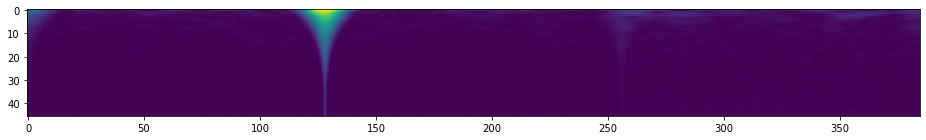

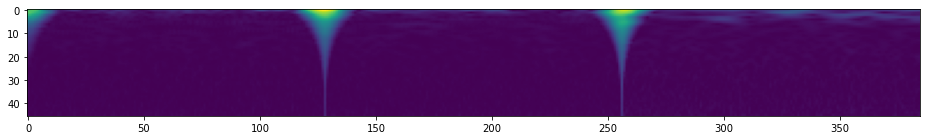

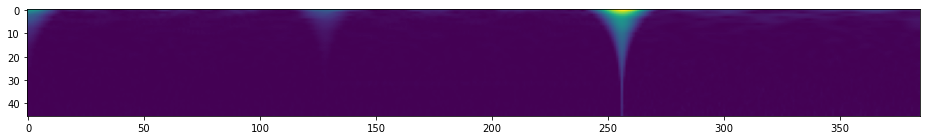

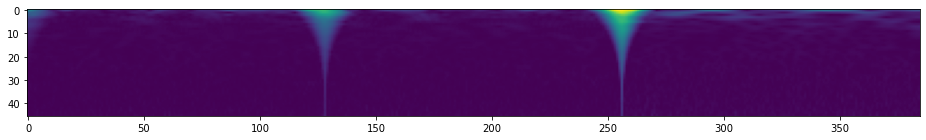

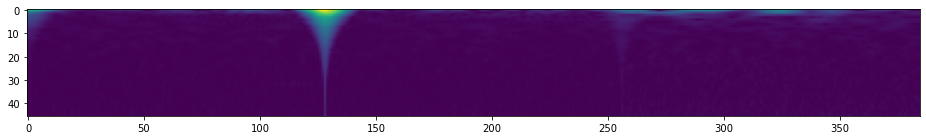

In [30]:
from matplotlib import pyplot as plt

test_dataset = TestDataset(test, transform=get_transforms(data='valid'))

for i in range(5):
    plt.figure(figsize=(16,12))
    image = test_dataset[i]
    plt.imshow(image[0])
    plt.show() 

# MODEL

In [31]:
# ====================================================
# MODEL
# ====================================================
class CustomModel(nn.Module):
    def __init__(self, cfg, pretrained=False):
        super().__init__()
        self.cfg = cfg
        self.model = timm.create_model(self.cfg.model_name, pretrained=pretrained, in_chans=1)
        self.n_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(self.n_features, self.cfg.target_size)

    def forward(self, x):
        output = self.model(x)
        return output

# inference

In [32]:
# ====================================================
# inference
# ====================================================
def inference(model, states, test_loader, device):
    model.to(device)
    tk0 = tqdm(enumerate(test_loader), total=len(test_loader))
    probs = []
    for i, (images) in tk0:
        images = images.to(device)
        avg_preds = []
        for state in states:
            model.load_state_dict(state['model'])
            model.eval()
            with torch.no_grad():
                y_preds = model(images)
            avg_preds.append(y_preds.sigmoid().to('cpu').numpy())
        avg_preds = np.mean(avg_preds, axis=0)
        probs.append(avg_preds)
    probs = np.concatenate(probs)
    return probs

In [33]:
model = CustomModel(CFG, pretrained=False)
states = [torch.load(CFG.model_dir+f'{CFG.model_name}_fold{fold}_best_score.pth') for fold in CFG.trn_fold]
test_dataset = TestDataset(test, transform=get_transforms(data='valid'))
test_loader = DataLoader(test_dataset, batch_size=CFG.batch_size, shuffle=False, 
                         num_workers=CFG.num_workers, pin_memory=True)
predictions = inference(model, states, test_loader, device)

CQT kernels created, time used = 0.0065 seconds


  0%|          | 0/442 [00:00<?, ?it/s]

# Submission

In [34]:
test['target'] = predictions
test[['id', 'target']].to_csv('submission.csv', index=False)
test.head()

,id,target,file_path
0,00005bced6,1.000000,input/test/0/0/0/00005bced6.npy
1,0000806717,0.916555,input/test/0/0/0/0000806717.npy
2,0000ef4fe1,0.298802,input/test/0/0/0/0000ef4fe1.npy
3,00020de251,0.899446,input/test/0/0/0/00020de251.npy
4,00024887b5,0.225777,input/test/0/0/0/00024887b5.npy


<AxesSubplot:>

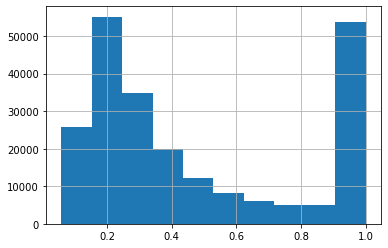

In [35]:
test['target'].hist()